<a href="https://colab.research.google.com/github/kerimdelic/MathForIndustry/blob/main/CBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A short description of the code
- The first block of code defines a Brownian Bridge. Also, an illustration is created.
- The second block of code defines a (log)likelihood function and finds the maximum likelihood estimate for the variance of the corresponding Brownian Bridge. 
- We zijn bezig geweest met onze estimatorfunctie testen op zelf gegenereerde data. Hij werkt redelijk goed. Is te zien in grafiek die in overleaf staat.
- Als we at random de helft van onze meetpunten vergeten, dan lijkt the estimator niet veel te veranderen. Dus hij blijft stabiel als je wat data kwijt raakt.
- We willen nu nog kijken naar wat die estimator doet als we 1000 punten achter elkaar kwijtraken
- Nu testen we de estimator vooral op data die gegenereerd is als Brownian bridge, een volgende stap zou zijn om te kijken of deze estimator voor variantie ook nuttige waardes geeft als we er data in gooien die op een andere manier is geboren.


*First part of the code generates 7 points {0,1,2,3,4,5,6}. Between the points {0,2}, {2,4} and {4,6} independent Brownian Bridges are being generated. Afterwards, we use the odd points 1,3 and 5 as a realisation of a Brownian bridge. For example, point 1 is a realisation of the Brownian bridge {0,2}. Based on these odd points, the MLE is calculated for $\sigma_m$. This gives the most likely mobility coefficient $\sigma_m$, which tells us how much the person deviates from the expected path, i.e. how mobil someone was on his journey from 0 to 6.*

blue path length is 89.094343
red path length is 93.994250
orange path length is 81.330813


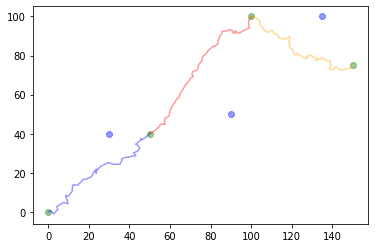

In [ ]:
from scipy import optimize 
import math
import numpy as np
import matplotlib.pyplot as plt
# First define a function that creates N brownian bridges with T time-steps.
# The starting coordinates are described by start and the end coordinates by target.
# The color represents the color of the path in the graph
def BrownianBridgeWithObservation(N, T, start, target, color):
    d = 2 # number of dimensions
    steps = np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)), size=(N, T)) # each coordinate is realised by a normal distribution, mu = [0,0] and sigma = [[1,0],[0,1]]
    walks = np.ones((N, T+1, d))*start[0]
    for i in range(T+1):
      walks[0][i][1] = start[1]
    walks[:,1:, :] += np.cumsum(steps, axis=1)
    t = np.arange(0, T+1, 1)
    walks += -np.swapaxes(np.tensordot(walks[:,-1,:],t/T, axes=0), 1, 2) + np.tensordot(t/T, target, axes=0)
    path_lengths = np.sum(np.linalg.norm(np.diff(walks, axis=1), axis=2), axis=1)
    print("%s path length is %f" % (color, np.mean(path_lengths)))
    for i in range(N):
        plt.plot(walks[i,:,0], walks[i,:,1], color=color, alpha=0.4)

BrownianBridgeWithObservation(1,50,[0,0], [50,40], 'blue')
BrownianBridgeWithObservation(1,50,[50,40], [100,100], 'red')
BrownianBridgeWithObservation(1,50,[100,100], [150, 75], 'orange')
point1 = [30,40]
point2 = [90, 50]
point3 = [135, 100]
plt.scatter(point1[0], point1[1], color = 'blue', alpha=0.4)
plt.scatter(point2[0], point2[1], color = 'blue', alpha=0.4)
plt.scatter(point3[0], point3[1], color = 'blue', alpha=0.4)
plt.scatter(0, 0, color = 'green', alpha=0.4)
plt.scatter(50, 40, color = 'green', alpha=0.4)
plt.scatter(100, 100, color = 'green', alpha=0.4)
plt.scatter(150, 75, color = 'green', alpha=0.4)
start = [[0,0], [50,40], [100,100]]
end = [[50,40], [100,100], [150,70]]
points = [point1, point2, point3]
plt.show()


89.89362901801402 0.0
50.0


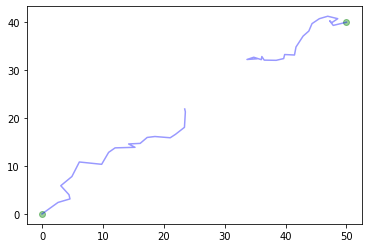

In [ ]:
def BrownianBridgeWithMissing(N, T, start, target, color):
    d = 2 # number of dimensions
    steps = np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)), size=(N, T)) # each coordinate is realised by a normal distribution, mu = [0,0] and sigma = [[1,0],[0,1]]
    walks = np.ones((N, T+1, d))*start[0]
    for i in range(T+1):
      walks[0][i][1] = start[1]
    walks[:,1:, :] += np.cumsum(steps, axis=1)
    t = np.arange(0, T+1, 1)
    walks += -np.swapaxes(np.tensordot(walks[:,-1,:],t/T, axes=0), 1, 2) + np.tensordot(t/T, target, axes=0)
    path_lengths = np.sum(np.linalg.norm(np.diff(walks, axis=1), axis=2), axis=1)
    print(np.mean(path_lengths), np.std(path_lengths))
    for i in range(N):
        plt.plot(walks[i,:,0][0:20], walks[i,:,1][0:20], color=color, alpha=0.4)
        plt.plot(walks[i,:,0][30:51], walks[i,:,1][30:51], color=color, alpha=0.4)
    #plt.hist2d(walks[:,1:-1,0].flatten(), walks[:, 1:-1, 1].flatten(), bins=100)
    #plt.show()
    print(walks[0,:,0][50])

BrownianBridgeWithMissing(1,50,[0,0], [50,40], 'blue')
plt.scatter(0, 0, color = 'green', alpha=0.4)
plt.scatter(50, 40, color = 'green', alpha=0.4)
plt.savefig('path_with_gap.pdf')
plt.show()

*In the following block we will define the (log)likelihood function and derive the MLE by using ternary search.*


Hoogste likelyhood van 0.01 tm 1.00 0.09
Ternarysearch naar meest waarschijnlijk 0.09201046246724963


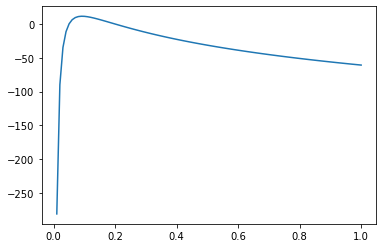

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
def randompad(lengtepad): # This function creates a random path that slowly drifts to the right corner
    randompad=[[0,0,0]]
    steps=np.random.rand(lengtepad-1,2)
    for x in range(lengtepad-1):
        nieuwpunt=[randompad[-1][0]+steps[x][0],randompad[-1][1]+steps[x][1],randompad[-1][2]+1]
        randompad.append(nieuwpunt)
    return randompad
def likelyhood(sigmakwadraat,pad): # The likelihood function for a Brownian Brdige path with a certain sigma_m 
    prod=1
    factoren=(len(pad)-1)//2 # aantal punten dat we invullen
    for x in range(factoren):
        begin=pad[2*x]
        testpunt=pad[2*x+1]
        eind=pad[2*x+2]
        deltabegin=0
        deltaeind=0
        Ti=eind[2]-begin[2]
        alphai=(testpunt[2]-begin[2])/Ti
        mui=[begin[0]+alphai*(eind[0]-begin[0]),begin[1]+alphai*(eind[1]-begin[1])]
        sigmakwadraati=Ti*alphai*(1-alphai)*sigmakwadraat+((1-alphai)*deltabegin)**2+(alphai*deltaeind)**2
        exponenti=-((testpunt[0]-mui[0])**2+(testpunt[1]-mui[1])**2)/(2*sigmakwadraati)
        factor=np.exp(exponenti)/(2*math.pi*sigmakwadraati)
        prod*=factor
    return prod
def loglikelyhood(sigmakwadraat,pad): # Een functie die log(L) uitrekent en simpelere tussenstappen heeft (som ipv product door log)
    som=0
    termen=(len(pad)-1)//2
    for x in range(termen):
        begin=pad[2*x]
        testpunt=pad[2*x+1]
        eind=pad[2*x+2]
        deltabegin=0
        deltaeind=0
        Ti=eind[2]-begin[2]
        alphai=(testpunt[2]-begin[2])/Ti
        mui=[begin[0]+alphai*(eind[0]-begin[0]),begin[1]+alphai*(eind[1]-begin[1])]
        sigmakwadraati=Ti*alphai*(1-alphai)*sigmakwadraat+((1-alphai)*deltabegin)**2+(alphai*deltaeind)**2
        exponenti=-((testpunt[0]-mui[0])**2+(testpunt[1]-mui[1])**2)/(2*sigmakwadraati)
        #factor=np.exp(exponenti)/(2*math.pi*sigmakwadraati)
        som+=-np.log(2*math.pi*sigmakwadraati)+exponenti
    return som
def mostlikelyschatter(pad): # Gegeven een pad geeft deze functie de schatter van sigma^2 terug. Werkt met ternary search.
    links=0.001
    a=loglikelyhood(links,pad)
    b=loglikelyhood(links/2,pad)
    while(b>a):
        a=b
        links/=2
        b=loglikelyhood(links/2,pad)
    rechts=1000
    a=loglikelyhood(rechts,pad)
    b=loglikelyhood(rechts*2,pad)
    while(b>a):
        a=b
        rechts*=2
        b=loglikelyhood(rechts*2,pad)
    midden=(links+rechts)/2
    linkswaarde=loglikelyhood(links,pad)
    rechtswaarde=loglikelyhood(rechts,pad)
    while(rechts-links>0.0000001):
        m1=(2*links+rechts)/3
        m2=(links+2*rechts)/3
        m1waarde=loglikelyhood(m1,pad)
        m2waarde=loglikelyhood(m2,pad)
        if m1waarde>m2waarde:
            rechts=m2
        else:
            links=m1
    return (links+rechts)/2
            
def plotter(pad): # plot een pad
    x=[a[0] for a in pad]
    y=[a[1] for a in pad]
    T=pad[-1][2]-pad[0][2]
    for a in range(len(pad)-1):
        t=(pad[a][2]+pad[a+1][2])/2
        plt.plot([x[a],x[a+1]],[y[a],y[a+1]],color=(t/T,0,0))
    #plt.plot(x,y,"o",color="blue")
    plt.title("Pad dat loopt van zwart naar rood")
    plt.show()

pad1=[[0,0,0],[0,1,1],[0,2,2],[1,2,3],[1,3,4]] # Paden zijn hier lijsten met steeds punten [x,y,t]
pad2=randompad(100)
x=[]
pad3 = [[0,0,0], [100,100,10]]
print()
for a in range(100):
    x.append((a+1)/100)
y=np.array([loglikelyhood(a,pad2) for a in x])
plt.plot(x,y)
print("Hoogste likelyhood van 0.01 tm 1.00",x[np.argmax(y)])
print("Ternarysearch naar meest waarschijnlijk",mostlikelyschatter(pad2))

Feller process

In [ ]:
from scipy import optimize 
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def New_state(state, P): # Returns a new position given the current position and state.
# Intput: State: walking right = np.array([1,0,0,0,0]), walking up, walking left, walking down, staionary = np.array([0,0,0,0,1]) 
#         P is a probability matrix np.array([[p11,p21,...,pn1],[p21,...],...,[pn1,...pnn]]).
# Output: one state e.g. np.array([0,0,0,0,1]).
    n= random.random()
    P_next = np.matmul(P,state)
    i=0
    Sum = np.cumsum(P_next)
    while i < len(P_next):
        if n<Sum[i]:
            return np.array([0]*i+[1]+[0]*(len(P_next)-i-1))
        i += 1
        
def rot90(A,n): # Rotates a coordinate 90*n degrees.
    # Input: A = an array of length two [a,b]. n = an integer.
    # Output: an array of lenght two [b, -a].
    A_new = A
    for i in range(n):
        A_new = [A_new[1],-A_new[0]]
    return A_new

def Power_matrix(M, n): # Returns the n'th power of the matrix M.
    # Input: M = a 5x5 matrix, n = an integer.
    # Output: a 5x5 matrix.
    Id = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]
    for i in range(n):
        Id = np.matmul(Id, M)
    return Id

In [ ]:
def StatePosition_check(walk, state, target_state, target_position):
    # Checks if the final state and position are equivalent up to symetry to the end position and state
    #     and transfroms the walk to match the desired end point and state.
    # Input: walk = an array containing coordinates, (target_)state = a list of length 5 with 4 zeroes and 1 one, position one coordinate. 
    # Output: a list with the first element a boolean which is True if the final state/position matches the state/position
    # Up to symmetry and False else. and second element the transformed desired walk of true and origenal walk if false. 
    
    R = np.array([[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[1,0,0,0,0],[0,0,0,0,1]]) 
    # The matrix that rotates the state to match the rotated position.
    for i in range(4):
        if np.all(np.array(rot90(walk[-1],i)) == np.array(target_position)): 
            # Checks if final position of the walk is a rotation of the desired target position.
            if np.all(target_state == np.matmul(Power_matrix(R, i), state)): 
                # Checks if final state of the walk is a rotation of the desired target state.
                desired_walk = [rot90(j,i) for j in walk] # Adjusts the current walk to the desired walk. 
                return [True, desired_walk]
            else :
                return [False, walk]
            
    for i in range(4):   # Check the same things as above but now first a mirroring in the x = y axis.  
        if np.all(np.array(rot90(np.flip(walk[-1]),i)) == np.array(target_position)): 
            if np.all(target_state == np.matmul(Power_matrix(R, i+3), state)): # Note the i+3 to compensate for the mirorring.
                desired_walk = [rot90(np.flip(j),i) for j in walk]
                return [True, desired_walk]
            else :
                return [False, walk]
            
    else:
        return [False, walk]

In [ ]:
def FellerProces(N, T, start_state, start_position, target_state, target_position,P): 
# Returns a set of N walks with T steps (some might be stationary) with specified start- and end-position and -state.
# Input: N = an integer, T an integer, start/target-state an np.array, start/target-position a regular array, P a probability matrix as above.
# Output: A list of walks, with in it seperate lists which represent single walks. A single walk is a list of T coordinates.
# E.g. an output could be [[[0,0],[0,1],[1,1],[1,0],[1,0],[0,0]], [[0,0],[0,-1],[0,-2],[0,-1],[0,0],[0,0]]].
    if abs(target_position[0])+abs(target_position[1])>T:
        print("target can not be reached")
        return None
    i = 0
    walks = []
    while i< N: # Now we get N paths from the process.
        state = start_state
        steps = [start_position]
        t = 0 # This way we will make T steps, form t = 0 to t = T-1.
        while t < T:
            state = New_state(state, P)
            if np.all(state == [1, 0, 0, 0, 0]): # step to the right
                steps = steps + [[1, 0]]
            elif np.all(state == [0, 1, 0, 0, 0]): #step up
                steps = steps + [[0, 1]]
            elif np.all(state == [0, 0, 1, 0, 0]): #step left
                steps = steps + [[-1, 0]]
            elif np.all(state == [0, 0, 0, 1, 0]): #step down
                steps = steps + [[0, -1]]
            else:#                          don't move
                steps = steps + [[0, 0]]
            t += 1
        walk = np.cumsum(steps, axis = 0) #make the path by summing the steps.
        if StatePosition_check(walk, state, target_state, target_position)[0]: # Check if the path has correct end position.
            walks.append(StatePosition_check(walk, state, target_state, target_position)[1]) # Collect all the good walks.
        else:
            continue # Make a random new path.
        i += 1
    return walks

example values for feller process

[20, 20, 20, 30, 26, 20, 28, 26, 22, 22, 20, 20, 24, 24, 20, 26, 20, 26, 28, 32, 20, 22, 20, 20, 20, 22, 26, 20, 30, 20] 23.133333333333333


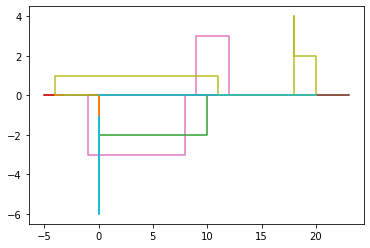

In [ ]:
P_1 = 0.80 # Chance to keep moving in one direction.
P_2 = 0.09 # Chance to make a 90 degree turn (in any direction, so the sum of going right or going left).
P_3 = 0.01 # Chance to make a 180 degree turn
P_4 = 0.10 # Chance to stop moving = chance to start moving (in any direction, so the sum of going right, left, up or down).
P_5 = 0.90 # Chance to stay standing still.
# Note that we always need P_1+P_2+P_3+P4 = 1 and P_4+P_5 = 1.
P = np.array([[P_1,P_2/2,P_3,P_2/2,P_4/4],[P_2/2,P_1,P_2/2,P_3,P_4/4],[P_3,P_2/2,P_1,P_2/2,P_4/4],[P_2/2,P_3,P_2/2,P_1,P_4/4],[P_4,P_4,P_4,P_4,P_5]])
# Changing these values can change how many turns the walks make, and way more lets look at realistic options later.
start_state = np.array([0,0,0,0,1])
start_position = [0,0]
target_state = np.array([0,0,0,0,1])
target_position = [20, 0]
T = 50 # I wouldn't put in values over a 100 since the process is random and will start to take significantly longer from then on.
N = 30
a = FellerProces(N, T, start_state, start_position, target_state, target_position,P)

plt.plot([[a[j][i][0] for j in range(len(a))] for i in range(len(a[0]))], [[a[j][i][1] for j in range(len(a))] for i in range(len(a[0]))])
# Plots N walks between the start position/state and target position/state consisting of T steps.

# Now we calculate the distance of each path and the mean distance.
distances = []
for i in a: # Take every walk.
    k=0
    for j in range(len(i)-1): # Take every step in each walk.
        r = np.array(i[j+1])-np.array(i[j]) # The difference in coordinates between two time steps.
        k += abs(r[0])+abs(r[1]) # The distance between these coordinates. 
    distances.append(k)
print(distances, np.mean(distances))

In [ ]:
from scipy import optimize 
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def New_state(state, P): #returns a new position given the current position and state 
# Intput: State: walking right = np.array([1,0,0,0,0]), walking up, walking left, walking down, staionary = np.array([0,0,0,0,1]) 
#         P is a probability matrix np.array([[p11,p21,...,pn1],[p21,...],...,[pn1,...pnn]])
# Output: one state e.g. np.array([0,0,0,0,1])
    n= random.random()
    U = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
    P_next = np.matmul(P,np.array(U[state])) # = [P[0][state],P[1][state],P[2][state],P[3][state],P[4][state]]
    i=0
    Sum = np.cumsum(P_next)
    while i < len(P_next):
        if n<Sum[i]:
            return i #np.array([0]*i+[1]+[0]*(len(P_next)-i-1))
        i += 1
        
def rot90(A,n): #rotates a coordinate 90*n degrees.
    #input: A = an array of length two [a,b]. n = an integer.
    #output: an array of lenght two [b, -a]
    A_new = A
    for i in range(n):
        A_new = [A_new[1],-A_new[0]]
    return A_new


def Power_matrix(M, n): #returns the n'th power of the matrix M.
    #input: M = a 5x5 matrix, n = an integer.
    #Output: a 5x5 matrix.
    Id = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]
    for i in range(n):
        Id = np.matmul(Id, M)
    return Id

def StatePosition_check(walk, state, target_state, target_position):
    # checks if the final state and position are equivalent up to symetry to the end position and state.
    # and transfroms the walk to match the desired end point and state.
    # Input: walk = an array containing coordinates, (target_)state = a list of length 5 with 4 zeroes and 1 one, position one coordinate. 
    # Output: a list with the first element a boolean which is True if the final state/position matches the state/position
    # up to symmetry and False else. and second element the transformed desired walk of true and origenal walk if false. 
    W = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]
    R = np.array([[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[1,0,0,0,0],[0,0,0,0,1]]) 
    # the matrix that rotates the state to match the rotated position.
    for i in range(4):
        if np.all(np.array(rot90(walk[-1],i)) == np.array(target_position)): 
            #checks if final position of the walk is a rotation of the desired target position.
            if np.all(np.array(W[target_state]) == np.matmul(Power_matrix(R, i), np.array(W[state]))): 
                # checks if final state of the walk is a rotation of the desired target state.
                desired_walk = [rot90(j,i) for j in walk] # adjusts the current walk to the desired walk. 
                return [True, desired_walk]
            else :
                return [False, walk]
            
    for i in range(4):   #check the same things as above but now first a mirroring in the   
        if np.all(np.array(rot90(np.flip(walk[-1]),i)) == np.array(target_position)): 
            if np.all(np.array(W[target_state]) == np.matmul(Power_matrix(R, i+3), np.array(W[state]))): #note the i+3 to compensate for the mirorring.
                desired_walk = [rot90(np.flip(j),i) for j in walk]
                return [True, desired_walk]
            else :
                return [False, walk]
            
    else:
        return [False, walk]

def FellerProces(N, T, start_state, start_position, target_state, target_position,P): 
#Returns a set of N walks with T steps (some might be stationary) with specified start- and end-position and -state.
#Input: N = an integer, T an integer, start/target-state an np.array, start/target-position a regular array, P a probability matrix as above.
#Output: A list of walks, with in it seperate lists which represent single walks. A single walk is a list of T coordinates.
# E.g. an output could be [[[0,0],[0,1],[1,1],[1,0],[1,0],[0,0]], [[0,0],[0,-1],[0,-2],[0,-1],[0,0],[0,0]]]
    if abs(target_position[0])+abs(target_position[1])>T:
        print("target can not be reached")
        return None
    i = 0
    walks = []
    while i < N: #now we get N paths from the process
        state = start_state
        steps = [start_position]
        t = 0 #this way we will make T steps, form t = 0 to t = T-1.
        V =[[[1,0]],[[0,1]],[[-1,0]],[[0,-1]],[[0,0]]]
        while t < T:
            state = New_state(state, P)
#             if np.all(state == [1, 0, 0, 0, 0]): # step to the right
#                 steps = steps + [[1, 0]]
#             elif np.all(state == [0, 1, 0, 0, 0]): #step up
#                 steps = steps + [[0, 1]]
#             elif np.all(state == [0, 0, 1, 0, 0]): #step left
#                 steps = steps + [[-1, 0]]
#             elif np.all(state == [0, 0, 0, 1, 0]): #step down
#                 steps = steps + [[0, -1]]
#             else:#                          don't move
#                 steps = steps + [[0, 0]]
            steps = steps + V[state]
            t += 1
#         if np.any(target_state != state): #check if the path has correct end state, else it makes a random new path.
#             continue
        walk = np.cumsum(steps, axis = 0) #make the path by summing the steps.
#         if np.any(np.array(walk[-1]) != np.array(target_position)): #check if the path has correct end position, else it makes a random new path.
#             continue
        if StatePosition_check(walk, state, target_state, target_position)[0]:
            walks.append(StatePosition_check(walk, state, target_state, target_position)[1])# collect all the good walks
        else:
            continue
        i += 1
    return walks

[50, 40, 54, 42, 36, 42, 48, 44, 38, 50] 44.4


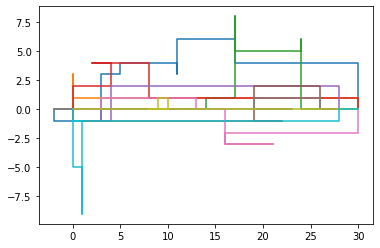

In [ ]:
P_1 = 0.70 # chance to keep moving in one direction
P_2 = 0.08 # chance to make a 90 degree turn (in any direction, so the sum of going right or going left.)
P_3 = 0.02 # chance to make a 180 degree turn
P_4 = 1-P_1-P_2-P_3 # chance to stop moving.
P_5 = 0.9 # chance to stay standing still
P_6 = 1-P_5# Chance to start moving (in any direction, so the sum of going right, left, up or down.)
#Note that we always need P_1+P_2+P_3+P4 = 1 and P_4+P_5 = 1.
P = np.array([[P_1,P_2/2,P_3,P_2/2,P_6/4],[P_2/2,P_1,P_2/2,P_3,P_6/4],[P_3,P_2/2,P_1,P_2/2,P_6/4],[P_2/2,P_3,P_2/2,P_1,P_6/4],[P_4,P_4,P_4,P_4,P_5]])
start_state = 4
#state 0 = [1,0,0,0,0], 1 = [0,1,0,0,0], ..., 4 = [0,0,0,0,1].
start_position = [0,0]
target_state = 4
target_position = [30, 0]
T = 100
N = 10
a = FellerProces(N, T, start_state, start_position, target_state, target_position,P)
plt.plot([[a[j][i][0] for j in range(len(a))] for i in range(len(a[0]))], [[a[j][i][1] for j in range(len(a))] for i in range(len(a[0]))])
distances = []
for i in a:
    k=0
    for j in range(len(i)-1):
        r = np.array(i[j+1])-np.array(i[j])
        k += abs(r[0])+abs(r[1])
    distances.append(k)
print(distances, np.mean(distances))

genereren van testpaden met een feller proces:

In [ ]:
from scipy import optimize 
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def state_evolution(N, T, probabilities, number_of_states, start_state):
    options = list(range(number_of_states))
    states = np.zeros((N, T+1)).astype(int)
    states[:, 0] = start_state
    for t in range(1, T+1):
        for i in range(number_of_states):
            states_mask = (states[:,t-1] == i)
            states[states_mask, t] = np.random.choice(options, size=np.sum(states_mask), replace=True, p = probabilities[i])
    return states

def function(S):
    P_1 = 0.70*(1-S)+ 0.25*S # chance to keep moving in one direction
    P_2 = 0.08*(1-S)+ 0.25*S # chance to make a 90 degree turn (in any direction, so the sum of going right or going left.)
    P_3 = 0.02*(1-S)+ 0.25*S # chance to make a 180 degree turn
    P_4 = (1-P_1-P_2-P_3) # chance to stop moving.
    P_5 = 0.9*(1-S)+ 0.5*S # chance to stay standing still
    P_6 = 1-P_5# Chance to start moving (in any direction, so the sum of going right, left, up or down.)
    #Note that we always need P_1+P_2+P_3+P4 = 1 and P_4+P_5 = 1.
    P = np.array([[P_1,P_2/2,P_3,P_2/2,P_6/4],[P_2/2,P_1,P_2/2,P_3,P_6/4],[P_3,P_2/2,P_1,P_2/2,P_6/4],[P_2/2,P_3,P_2/2,P_1,P_6/4],[P_4,P_4,P_4,P_4,P_5]])
    number_of_states = 5
    start_state = 4
    number_of_paths = 1
    length_of_paths = 200
    states = state_evolution(number_of_paths , length_of_paths, P.T, number_of_states, start_state)
    V = np.array([[1,0],[0,1],[-1,0],[0,-1],[0,0]])
    walks = np.cumsum(V[states],axis =1)
    return walks

print(walks)

[[[ 0  0]
  [ 0  0]
  [ 0  0]
  [ 0  0]
  [ 0  0]
  [ 1  0]
  [ 2  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  0]
  [ 3  1]
  [ 3  1]
  [ 2  1]
  [ 1  1]
  [ 1  1]
  [ 1  1]
  [ 1  1]
  [ 1  1]
  [ 1  0]
  [ 0  0]
  [-1  0]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  1]
  [-1  0]
  [ 0  0]
  [ 1  0]
  [ 2  0]
  [ 3  0]
  [ 4  0]
  [ 5  0]
  [ 6  0]
  [ 6  0]
  [ 6  0]
  [ 6  0]
  [ 5  0]
  [ 5  1]
  [ 5  1]
  [ 5  1]
  [ 5  2]
  [ 5  3]
  [ 5  4]
  [ 5  5]
  [ 5  6]
  [ 5  7]
  [ 5  8]
  [ 5  9]
  [ 4  9]
  [ 3  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  9]
  [ 2  8]
  [ 2  7]
  [ 2  8]
  [ 2  9]
  [ 2 10]
  [ 2 11]


# Nieuwe sectie

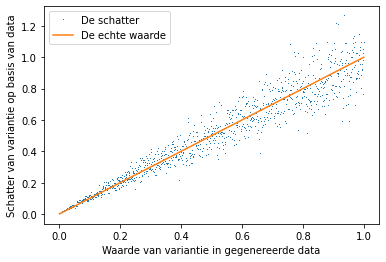

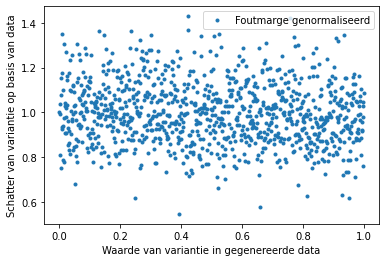

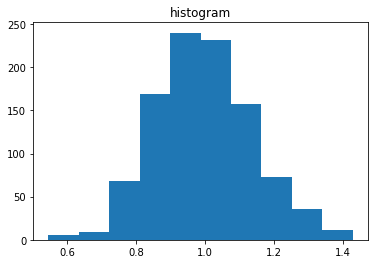

In [ ]:
#import math
#import numpy as np
#import matplotlib.pyplot as plt
#np.random.seed(13412213)
#def randompad(lengtepad): # Deze functie maakt een random pad dat langzaam naar rechtsboven loopt
#    randompad=[[0,0,0]]
#    steps=np.random.rand(lengtepad-1,2)
#    for x in range(lengtepad-1):
#        nieuwpunt=[randompad[-1][0]+steps[x][0],randompad[-1][1]+steps[x][1],randompad[-1][2]+1]
#        randompad.append(nieuwpunt)
#    return randompad
def BrownianBridge(begin,eind,T,sigmakwadraat):
    N=1
    d=2
    target=np.array([eind[0]-begin[0],eind[1]-begin[1]])
    steps = np.random.multivariate_normal(np.zeros(2), sigmakwadraat*np.diag(np.ones(2)), size=(N, T))
    walks = np.zeros((N, T+1, d))
    walks[:,1:, :] += np.cumsum(steps, axis=1)
    t = np.arange(0, T+1, 1)
    walks += -np.swapaxes(np.tensordot(walks[:,-1,:],t/T, axes=0), 1, 2) + np.tensordot(t/T, target, axes=0)
    path_lengths = np.sum(np.linalg.norm(np.diff(walks, axis=1), axis=2), axis=1)
    #print(path_lengths)
    res=[]
    for i in range(T+1):
        punt=walks[0,i,:]
        res.append([punt[0]+begin[0],punt[1]+begin[1],i])
    return res

            
def plotter(pad): # plot een pad
    x=[a[0] for a in pad]
    y=[a[1] for a in pad]
    T=pad[-1][2]-pad[0][2]
    for a in range(len(pad)-1):
        t=(pad[a][2]+pad[a+1][2])/2
        plt.plot([x[a],x[a+1]],[y[a],y[a+1]],color=(t/T,0,0))
    #plt.plot(x,y,"o",color="blue")
    plt.title("Pad dat loopt van zwart naar rood")
    plt.show()
def plotter2(pad):
    plt.plot([a[0] for a in pad],[a[1] for a in pad],label="pad met schatter "+str(mostlikelyschatter(pad)))

aantalsigmas=1000
sigmakwadraats=[]
for x in range(aantalsigmas):
    sigmakwadraats.append((x+1)/aantalsigmas)
y1=[]
y2=sigmakwadraats
for x in range(aantalsigmas):
    waarde=mostlikelyschatter(BrownianBridge([0,0],[100,0],100,sigmakwadraats[x]))
    y1.append(waarde)

plt.plot(sigmakwadraats,y1,",",label="De schatter")
plt.plot(sigmakwadraats,y2,label="De echte waarde")
plt.legend()
plt.xlabel("Waarde van variantie in gegenereerde data")
plt.ylabel("Schatter van variantie op basis van data")
plt.show()


normalized=[y1[i]/y2[i] for i in range(aantalsigmas)]
plt.plot(sigmakwadraats,normalized,".",label="Foutmarge genormaliseerd")
plt.legend()
plt.xlabel("Waarde van variantie in gegenereerde data")
plt.ylabel("Schatter van variantie op basis van data")
plt.show()

plt.hist(normalized,bins=aantalsigmas//100) 
plt.title("histogram") 
plt.show()

[[0 0 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 1 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 2 1 1]
 [0 0 0 ... 1 1 1]]


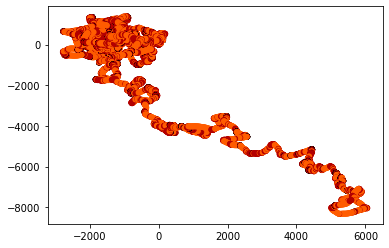

In [ ]:
# Aim of this code is to generate a few simple processes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def state_evolution(N, T, probabilities, number_of_states, start_state):
    options = np.array(range(number_of_states))
    states = np.zeros((N, T)).astype(int)
    states[:, 0] = start_state
    for t in range(1, T):
        for i in range(number_of_states):
            states_mask = (states[:,t-1] == i)
            states[states_mask, t] = np.random.choice(options, size=np.sum(states_mask), replace=True, p = probabilities[i])
    return states


def momentum_random_walk(N, T, sigma=1, d = 2):
  accelerations = np.random.multivariate_normal(np.zeros(d), sigma*np.diag(np.ones(d)), size=(N, T))
  momenta = np.cumsum(accelerations, axis = 1)
  positions = np.zeros((N, T + 1, d))
  positions[:, 1:, :] += np.cumsum(momenta, axis = 1)
  t = np.arange(0, T + 1, 1)
  return (positions, t)

def fixed_velocity_random_walk(N, T, velocity = 1, d = 2):
  steps = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), size=(N, T))
  steps = velocity*steps/np.linalg.norm(steps,axis=2)[:,:,np.newaxis]
  walks = np.zeros((N, T+1, d))
  walks[:, 1:, :] += np.cumsum(steps, axis = 1)
  t = np.arange(0, T + 1, 1)
  return (walks, t)

def normalized_add(x, y):
  return (x + y)/np.linalg.norm(x + y)

np_normalized_add = np.frompyfunc(normalized_add, 2, 1, identity=0.0)

def fixed_angular_random_walk(N, T, velocity=1, sigma=1):
  angular_accelaration = np.random.normal(0, sigma, size=(N, T))
  angle = np.cumsum(angular_accelaration, axis=1)
  velocities = velocity*np.stack((np.cos(angle), np.sin(angle)), axis=-1)
  positions = np.zeros((N, T + 1, 2))
  positions[:, 1:, :] += np.cumsum(velocities, axis = 1)
  t = np.arange(0, T + 1, 1)
  return (positions, t)


def evolving_angular_walk(N, T, velocity=np.array([0, 10, 20]), probabilities=np.array([[0.9,0.1,0],[0.05, 0.8, 0.15],[0.01, 0.19, 0.8]]),sigmas=np.array([.5, 0.5, 0.1])):
  angular_accelaration = np.random.normal(0, 1, size=(N, T))
  states = state_evolution(N, T, probabilities, len(velocity), 0)
  print(states)
  angle = np.cumsum(sigmas[states]*angular_accelaration, axis=1)
  velocities = np.stack((velocity[states]*np.cos(angle), velocity[states]*np.sin(angle)), axis=-1)
  positions = np.zeros((N, T + 1, 2))
  positions[:, 1:, :] += np.cumsum(velocities, axis = 1)
  t = np.arange(0, T + 1, 1)
  return (positions, states, t)

def run_and_tumble(N, T, l = 1, velocity=1, d = 2):
  tumbles = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), size=(N, T))
  p = 1 - np.exp(-l)
  velocities = np.zeros((N, T, d))
  velocities[:, 0, :] = tumbles[:, 0, :]
  for i in range(1, T):
    changed = np.random.uniform(size=(N)) < p
    velocities[:, i, :] = np.swapaxes(changed *np.swapaxes(tumbles[:, i, :], 0, 1) + (1 - changed)*np.swapaxes(velocities[:, i - 1, :], 0, 1), 0, 1)
  positions = np.zeros((N, T + 1, 2))
  positions[:, 1:, :] += np.cumsum(velocities, axis = 1)
  t = np.arange(0, T + 1, 1)
  return (positions, t)

def mask(positions, t, start, end):
  bool_arr = (t < start) | (t >= end)
  return (positions[:, bool_arr, :], t[bool_arr])

# p, t = run_and_tumble(100, 1000, 0.02)
# plt.plot(p[0, :, 0],p[0, :, 1])
# plt.show()

# p, t = fixed_angular_random_walk(100, 1000, sigma=0.1)
# plt.plot(p[0, :, 0],p[0, :, 1])
# plt.show()

# p, t = momentum_random_walk(100, 1000)
# plt.plot(p[0, :, 0],p[0, :, 1])
# plt.show()

# p, t = fixed_velocity_random_walk(100, 1000)
# #p, t = mask(p, t, 50, 300)
# plt.plot(p[0, :, 0],p[0, :, 1])
# plt.show()


p, states, t = evolving_angular_walk(10, 10000)
plt.scatter(p[0, :-1, 0],p[0, :-1, 1], c=cm.hot(states[0,:]/4), edgecolors='none')
plt.show()

0.0 0.0 8.532648731276621 21.53254045567282


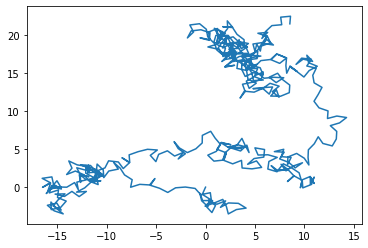

Actual path length =  [148.]
Pathlength of a straight line =  13.142210237272414
MLE sigma =  0.539514496459409


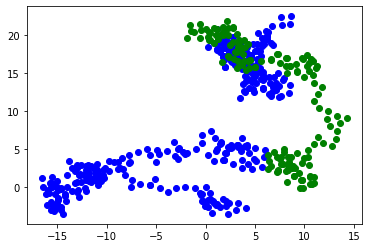

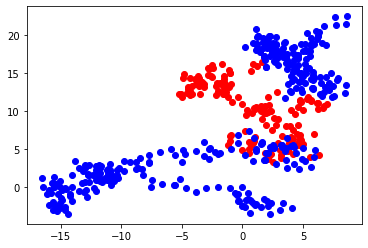

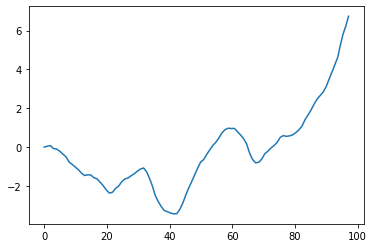

[28.]
MLE sigma 0.002695012774032954
length of straight line =  27.181210285203576


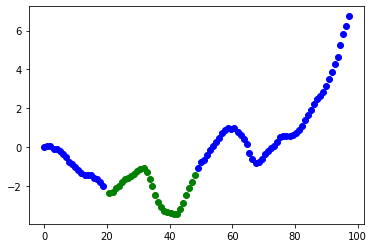

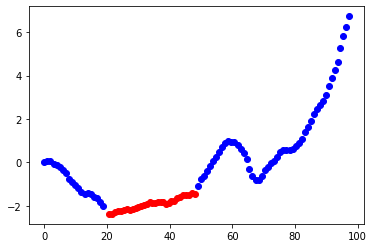

In [ ]:
def lijstmaker(svenpad):
    a=len(svenpad[0][0])
    lijst=[[] for i in range(a)]
    for x in range(a):
        lijst[x]=[svenpad[0][0][x][0],svenpad[0][0][x][1],svenpad[1][x]]
    return lijst
def missingpath(p, t, start, end):
  bool_arr = (t > start) & (t < end)
  return (p[:, bool_arr, :], t[bool_arr])

#momentum random walk 
p, t = fixed_velocity_random_walk(1, 500)
plt.plot(p[0, :, 0],p[0, :, 1])
print(p[0, :, 0][0],p[0, :, 1][0], p[0, :, 0][-1], p[0, :, 1][-1])
plt.show()
p1 = mask(p, t, 200, 350)
p2, t2 = mask(p, t, 200, 350)
plt.plot(p2[0, :, 0],p2[0, :, 1], 'bo')
lijst2 = lijstmaker(p1)
missingp, t = missingpath(p, t, 200, 350)
plt.plot(missingp[0, :, 0],missingp[0, :, 1], 'go')
path_length = np.sum(np.linalg.norm(np.diff(missingp, axis=1), axis=2), axis=1)
print("Actual path length = ", path_length)
result1 = BrownianBridge(missingp[0][0], missingp[0][-1], 150, mostlikelyschatter(lijst2))
print("Pathlength of a straight line = ", np.sqrt((missingp[0, :,0][-1]-missingp[0, :,0][0])**2+(missingp[0, :,1][-1]-missingp[0, :,1][0])**2))
print("MLE sigma = ", mostlikelyschatter(lijst2))
plt.show()
#plt.plot(result1[0, :, 0], reuslt1[0, :, 1])
#plt.show()
x = []
y =[]
for i in range(len(result1)):
  x.append(result1[i][0])
  y.append(result1[i][1])
plt.plot(x, y, 'ro')
plt.plot(p2[0, :, 0],p2[0, :, 1], 'bo')
plt.show()



#fixed angular random walk
farw, t = fixed_angular_random_walk(1, 100, sigma=0.1)
plt.plot(farw[0, :, 0],farw[0, :, 1])
plt.show()
slicedpath = mask(farw, t, 20,50)
p3 ,t3 = mask(farw, t, 20,50)
plt.plot(p3[0, :, 0],p3[0, :, 1], 'bo')
conversed_farw = lijstmaker(slicedpath)
conversedslicedpath, t =  missingpath(farw, t, 20,50)
path_length2 = np.sum(np.linalg.norm(np.diff(conversedslicedpath, axis=1), axis=2), axis=1)
print(path_length2)
print("MLE sigma", mostlikelyschatter(conversed_farw))
print("length of straight line = ", np.sqrt((conversedslicedpath[0, :,0][-1]-conversedslicedpath[0, :,0][0])**2+(conversedslicedpath[0, :,1][-1]-conversedslicedpath[0, :,1][0])**2))
plt.plot(conversedslicedpath[0, :, 0],conversedslicedpath[0, :, 1], 'go')
plt.show()
result2 = BrownianBridge(conversedslicedpath[0][0], conversedslicedpath[0][-1], 30, mostlikelyschatter(conversed_farw))
x = []
y =[]
for i in range(len(result2)):
  x.append(result2[i][0])
  y.append(result2[i][1])
plt.plot(x, y, 'ro')
plt.plot(p3[0, :, 0],p3[0, :, 1], 'bo')
plt.show()

2.283847730876653 -7.418909319209887
9.607026125059377


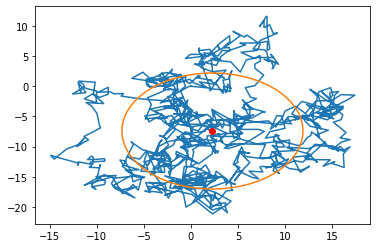

RoG of fixed velocity random walk =  7.584910295383548


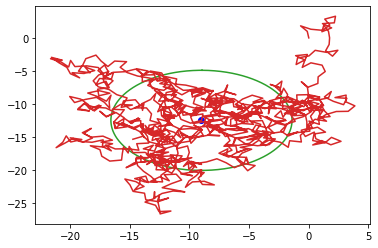

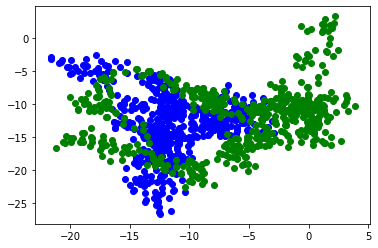

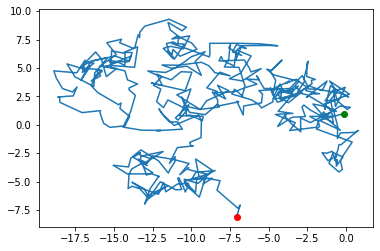

RoG after filling gap =  9.7914281038495
RoG after filling gap with straight line =  8.683545735233668


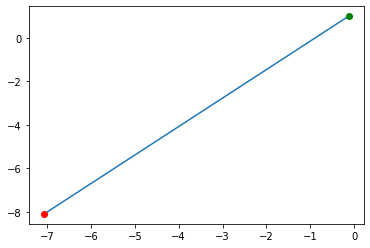

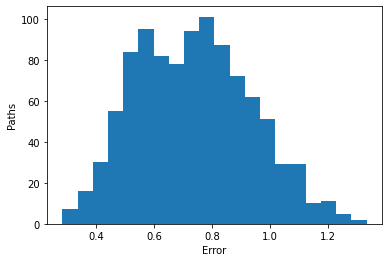

In [ ]:
T = 1000 # Number of time-steps
test = BrownianBridge([0,0], [0,0], T, 1) # Creates a Brown. Bridge that starts and ends at (0,0) with sigma_m = 1

def centre(path, t): # Creates centre
  xc = 0  
  yc = 0 
  for i in range(t):
    xc += path[i][0]/t
    yc += path[i][1]/t
  return xc, yc

def RoG(path, xc, yc, t): # Calculates the Radius of Gyration
  RoG = 0
  for i in range(t):
    RoG += ((path[i][0]-xc)**2 + (path[i][1]-yc)**2)/t
  RoG = np.sqrt(RoG)
  return RoG

XC = centre(test, T)[0]
YC = centre(test, T)[1]
print(XC, YC)
RoG = RoG(test, XC, YC, T)
print(RoG)

## For plotting purposes
x = []
y =[]
for i in range(len(test)):
  x.append(test[i][0])
  y.append(test[i][1])
plt.plot(x,y)
plt.plot(XC, YC, 'ro')
plt.plot([RoG*np.sin((i+1)*2*np.pi/1000)+XC for i in range(1001)], [RoG*np.cos((i+1)*2*np.pi/1000)+YC for i in range(1001)])
draw_circle = plt.Circle((XC, YC), RoG,fill=False)
plt.show()

####
####

p, t = fixed_velocity_random_walk(1, T)

def centre2(p, T, j):
  XC = 0
  YC = 0
  for i in range(T):
    XC += p[j][i][0]/T
    YC += p[j][i][1]/T
  return XC, YC

def RoG2(p, XC, YC, T, j):
  RoG = 0
  for i in range(T):
    RoG += ((p[j][i][0]-XC)**2 + (p[j][i][1]-YC)**2)/T
  RoG = np.sqrt(RoG)
  return RoG

XC = centre2(p,T,0)[0]
YC = centre2(p,T,0)[1]
#print(XC,YC)

RoG = RoG2(p, XC, YC, T, 0)
print("RoG of fixed velocity random walk = ", RoG)
x = []
y =[]
for i in range(len(p)):
  x.append(p[i][0])
  y.append(p[i][1])
plt.plot(x,y)
plt.plot(XC,YC, 'bo')
plt.plot([RoG*np.sin((i+1)*2*np.pi/1000)+XC for i in range(1001)], [RoG*np.cos((i+1)*2*np.pi/1000)+YC for i in range(1001)])
draw_circle = plt.Circle((XC, YC), RoG,fill=False)
plt.plot(p[0, :, 0],p[0, :, 1])
plt.savefig('rog.pdf')
plt.show()

####
def radiusafterfilling(p, t, j):
  T = 1000
  p1 = mask(p, t, 500, 1000)
  p2, t2 = mask(p, t, 500, 1000)
  lijst2 = lijstmaker(p1)
  missingp, t3 = missingpath(p, t, 500, 1000)
  startpos = [missingp[j][0][0], missingp[j][0][1]] 
  endpos = [missingp[j][-1][0], missingp[j][-1][1]]
  result1 = BrownianBridge(startpos, endpos, 500, mostlikelyschatter(lijst2))
  xc = 0
  yc = 0
  for i in range(0, 500):
    xc += result1[i][0]/T
    yc += result1[i][1]/T
  for i in range(500, 1000):
    xc += p[j][i][0]/T
    yc += p[j][i][1]/T

  RoG = 0
  for i in range(0,500):
    RoG += ((result1[i][0]-xc)**2 + (result1[i][1]-yc)**2)/T
  for i in range(500,1000):
    RoG += ((p[j][i][0]-xc)**2 + (p[j][i][1]-yc)**2)/T

  RoG = np.sqrt(RoG)
  return RoG

p1 = mask(p, t, 0, 500)
p2, t2 = mask(p, t, 0, 500)
plt.plot(p2[0, :, 0],p2[0, :, 1], 'bo')
lijst2 = lijstmaker(p1)
missingp, t = missingpath(p, t, 0, 500)
plt.plot(missingp[0, :, 0],missingp[0, :, 1], 'go')
start = [missingp[0][0][0], missingp[0][0][1]] 
end = [missingp[0][-1][0], missingp[0][-1][1]]
result1 = BrownianBridge(start, end, 500, mostlikelyschatter(lijst2))
plt.show()
x = []
y =[]
for i in range(len(result1)):
  x.append(result1[i][0])
  y.append(result1[i][1])
plt.plot(x,y)
plt.plot(start[0], start[1], 'go')
plt.plot(end[0], end[1], 'ro')
plt.show()
xc = 0
yc = 0
#for i in range(0,49):
#  xc += p[0][i][0]/N
#  yc += p[0][i][1]/N
for i in range(500):
  xc += result1[i][0]/T
  yc += result1[i][1]/T
for i in range(501,T):
  xc += p[0][i][0]/T
  yc += p[0][i][1]/T

RoG = 0
#for i in range(0,49):
# RoG += ((p[0][i][0]-xc)**2 + (p[0][i][1]-yc)**2)/N
for i in range(500):
 RoG += ((result1[i][0]-xc)**2 + (result1[i][1]-yc)**2)/T
for i in range(501,T):
 RoG += ((p[0][i][0]-xc)**2 + (p[0][i][1]-yc)**2)/T

RoG = np.sqrt(RoG)
print("RoG after filling gap = ", RoG)

RoG = 0
straightpath = [[] for i in range(500)]
straightpath[0] = start
for i in range(1,500):
  straightpath[i] = [straightpath[i-1][0] + (end[0]-start[0])/499, straightpath[i-1][1] + (end[1]-start[1])/499]
straightpath[-1] = end  
#print(straightpath)
#for i in range(0,49):
# RoG += ((p[0][i][0]-xc)**2 + (p[0][i][1]-yc)**2)/N
for i in range(500):
 RoG += ((straightpath[i][0]-xc)**2 + (straightpath[i][1]-yc)**2)/T
for i in range(500,T):
 RoG += ((p[0][i][0]-xc)**2 + (p[0][i][1]-yc)**2)/T

RoG = np.sqrt(RoG)
print("RoG after filling gap with straight line = ", RoG)

x = []
y =[]
for i in range(len(straightpath)):
  x.append(straightpath[i][0])
  y.append(straightpath[i][1])
plt.plot(x,y)
plt.plot(start[0], start[1], 'go')
plt.plot(end[0], end[1], 'ro')
plt.show()

def experiment(T):
  actualRoG = []
  afterRoG = []
  #p, t = fixed_angular_random_walk(1000, 1000, sigma=0.1)
  p, t = run_and_tumble(1000,1000)
  #p, t = fixed_velocity_random_walk(1000,1000)
  for i in range(1000):
    xc = centre2(p, T, i)[0]
    yc = centre2(p, T, i)[1]
    actualRoG.append(RoG2(p, xc, yc, T, i))
    afterRoG.append(radiusafterfilling(p, t, i))
  return actualRoG, afterRoG

test = experiment(1000)
actual = test[0]
procedure = test[1]
x = [i for i in range(1000)]
difference = []
for i in range(1000):
  difference.append(procedure[i]/actual[i])

plt.hist(difference, 20) 
#plt.title("Normalised Error")
plt.xlabel('Error')
plt.ylabel('Paths') 
plt.savefig('roghisto_runand.pdf')
plt.show()

In [ ]:
print(sum(difference)/1000)
print(sum(actual)/1000)
print(sum(procedure)/1000)
print(np.std(difference))

0.7368572304561903
25.692879574015915
18.129726681638942
0.1984910045642253


We are interested in a quantization of 

In [ ]:
sigma=[0.1,1,10]
def dis(a,b):
  return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
def f(s):
  NumberofSimulations=10
  res=[]
  for a in range(NumberofSimulations):
    Path=lijstmaker(fixed_angular_random_walk(1,200,sigma=s))
    ActualLength=sum([dis(Path[i],Path[i+1]) for i in range(199)])
    AvailableData=[]
    for x in range(50):
      AvailableData.append(Path[x])
    for x in range(150,200):
      AvailableData.append(Path[x])
    sigma=math.sqrt(mostlikelyschatter(AvailableData))
    T=100
    
    


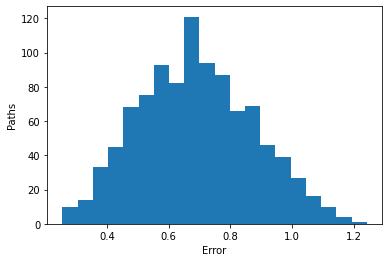

0.6897565866017139
25.436574724630482
16.933233170362776
0.1841714247138241


In [ ]:
## Filling with straight line RoG
T = 1000 # Number of time-steps

def centre(path, t): # Creates centre
  xc = 0  
  yc = 0 
  for i in range(t):
    xc += path[i][0]/t
    yc += path[i][1]/t
  return xc, yc

def RoG(path, xc, yc, t): # Calculates the Radius of Gyration
  RoG = 0
  for i in range(t):
    RoG += ((path[i][0]-xc)**2 + (path[i][1]-yc)**2)/t
  RoG = np.sqrt(RoG)
  return RoG



####
####



def centre2(p, T, j):
  XC = 0
  YC = 0
  for i in range(T):
    XC += p[j][i][0]/T
    YC += p[j][i][1]/T
  return XC, YC

def RoG2(p, XC, YC, T, j):
  RoG = 0
  for i in range(T):
    RoG += ((p[j][i][0]-XC)**2 + (p[j][i][1]-YC)**2)/T
  RoG = np.sqrt(RoG)
  return RoG


####
def radiusafterfillingstraight(p, t, j):
  T = 1000
  p1 = mask(p, t, 500, 1000)
  p2, t2 = mask(p, t, 500, 1000)
  lijst2 = lijstmaker(p1)
  missingp, t3 = missingpath(p, t, 500, 1000)
  startpos = [missingp[j][0][0], missingp[j][0][1]] 
  endpos = [missingp[j][-1][0], missingp[j][-1][1]]
  straightpath = [[] for i in range(500)]
  straightpath[0] = startpos
  for i in range(1,500):
    straightpath[i] = [straightpath[i-1][0] + (endpos[0]-startpos[0])/499, straightpath[i-1][1] + (endpos[1]-startpos[1])/499]
  straightpath[-1] = endpos  
  xc = 0
  yc = 0
  for i in range(0, 500):
    xc += straightpath[i][0]/T
    yc += straightpath[i][1]/T
  for i in range(500, 1000):
    xc += p[j][i][0]/T
    yc += p[j][i][1]/T

  RoG = 0
  for i in range(0,500):
    RoG += ((straightpath[i][0]-xc)**2 + (straightpath[i][1]-yc)**2)/T
  for i in range(500,1000):
    RoG += ((p[j][i][0]-xc)**2 + (p[j][i][1]-yc)**2)/T

  RoG = np.sqrt(RoG)
  return RoG


def experiment(T):
  actualRoG = []
  afterRoG = []
  #p, t = fixed_angular_random_walk(1000, 1000, sigma=0.1)
  #p, t = fixed_velocity_random_walk(1000,1000)
  p, t = run_and_tumble(1000,1000)
  for i in range(1000):
    xc = centre2(p, T, i)[0]
    yc = centre2(p, T, i)[1]
    actualRoG.append(RoG2(p, xc, yc, T, i))
    afterRoG.append(radiusafterfillingstraight(p, t, i))
  return actualRoG, afterRoG

test = experiment(1000)
actual = test[0]
procedure = test[1]
x = [i for i in range(1000)]
difference = []
for i in range(1000):
  difference.append(procedure[i]/actual[i])

plt.hist(difference, 20) 
plt.xlabel('Error')
plt.ylabel('Paths') 
#plt.title("Normalised Error") 
plt.savefig('rog_straight_runand.pdf')
plt.show()
print(sum(difference)/1000)
print(sum(actual)/1000)
print(sum(procedure)/1000)
print(np.std(difference))